# Tissue Classification using Neural Networks
In this lab we will explore the use of texture in images and traditional machine learning approaches such as clustering. The dataset we will be using is available here: http://dx.doi.org/10.5281/zenodo.53169. 

![alt text](https://www.researchgate.net/profile/Jakob_Kather/publication/303998214/figure/fig7/AS:391073710002224@1470250646407/Representative-images-from-our-dataset-Here-the-first-10-images-of-every-tissue-class.png)

The above figure shows the 8 different classes of tissue we will be trying to identify. 

In [0]:
# Imports
from __future__ import print_function
import os
import numpy as np
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from skimage.transform import rescale, resize, downscale_local_mean

## Step 1
* Load the data (done for you)
 * The "data" variable stores 5000 images of shape 150x150. This means data has shape (5000, 150, 150). These images are loaded here as grayscale.
 * The "labels" variable stores 5000 labels (0-7). This means "labels" has shape (5000,)
* Split data into training and testing subsets (left up to you)
 * Check out the sklearn function train_test_split from sklearn.model_selection

In [2]:
! git clone https://github.com/BeaverWorksMedlytics/Week3_public.git

# Build the path to the data folder. No need to change directories
# There are a total of 6 files you will have to load
data_dir = os.path.join( os.getcwd(), 'Week3_public', 'data', 'crc')

fatal: destination path 'Week3_public' already exists and is not an empty directory.


In [3]:
# Load data and split into training, testing sets
y = np.load(os.path.join(data_dir, 'rgb01.npz'))
labels = y['labels']
data = y['rgb_data']
data = data[:,:,:,0]
label_str = y['label_str']
label_str = label_str.tolist() # this is to convert label_str back to a dictionary
y = []

print(data.shape)
for ii in range(2,6):
    filename = os.path.join(data_dir, 'rgb0' + str(ii) + '.npz')
    print('loading ', filename)
    y = np.load(filename)
    labels = np.append(labels, y['labels'], axis=0)
    data = np.append(data, y['rgb_data'][:,:,:,0], axis=0)
    print(data.shape)
    y = []


print( data.shape )
print( labels.shape )

(1000, 150, 150)
loading  /content/Week3_public/data/crc/rgb02.npz
(2000, 150, 150)
loading  /content/Week3_public/data/crc/rgb03.npz
(3000, 150, 150)
loading  /content/Week3_public/data/crc/rgb04.npz
(4000, 150, 150)
loading  /content/Week3_public/data/crc/rgb05.npz
(5000, 150, 150)
(5000, 150, 150)
(5000,)


In [4]:
num_images, nrows, ncols = data.shape

test_size=0.2
train_size = 0.8

X_train, X_test, train_labels, test_labels = train_test_split(data, labels, test_size=test_size, random_state=0)
X_train = X_train.astype('float64')
X_test = X_test.astype('float64')

train_labels = to_categorical(train_labels, 8)
test_labels = to_categorical(test_labels, 8)

print(X_train.shape)
print(X_test.shape)
print(train_labels)
print(test_labels)

(4000, 150, 150)
(1000, 150, 150)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


## Normalize and Reshape Data
All images should be normalized to the range 0-1 by dividing by 255.

Additionally, because this is a ANN, not a CNN, we need to reshape the data to be one dimensional. In training and test data, colapse the row and column dimensions into one dimension using reshape().
#### Note
* Using the La\*b colorspace : If you convert your images to the La\*b colorspace, the scaling factor will change. Each channel in this colorspace will have a different range and normalization of each space will involve scaling each channel separately. Additionally, the a\* channel can have a negative range. This also needs to be taken into account. 
* Using the HSV/HSI colorspace : Similar considerations apply if you are using the HSV/HSI colorspace. The only difference is that the HSV/HSI colorspace will have all positive values.

In [5]:
# Assuming we are using the RGB colorspace
# Normalize all images so that they are 0-1
X_train_new = np.zeros((4000,64,64))
X_test_new = np.zeros((1000,64,64))

for i in range(len(X_train)):
  X_train_new[i] = resize(image=X_train[i], output_shape=(64, 64))

for i in range(len(X_test)):
  X_test_new[i] = resize(image=X_test[i], output_shape=(64, 64))
  
X_train = X_train_new
X_test = X_test_new
num_images, nrows, ncols = X_train.shape

for i in range(len(X_train)):
  X_train[i][0] = X_train[i][0]/255
  X_train[i][1] = X_train[i][1]/255
  X_train[i][2] = X_train[i][2]/255

for i in range(len(X_test)):
  X_test[i][0] = X_test[i][0]/255
  X_test[i][1] = X_test[i][1]/255
  X_test[i][2] = X_test[i][2]/255

X_train = X_train.reshape(4000, nrows*ncols)
X_test = X_test.reshape(1000, nrows*ncols)

print(X_train.shape, X_test.shape)

/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(4000, 4096) (1000, 4096)


## Step 2
At this point, the data has been split into training and testing sets and normalized. We will now design a fully connected neural network for texture classification. 

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" width="50%"></img>

( Image from http://cs231n.github.io/convolutional-networks/ )

When designing a fully connected network for classification, we have several decisions to make.

**Network Architecuture**
* How many layers will our network have ?
* How many neurons per layer ?
* What is an appropriate batch size, learning rate and number of training epochs ?

**Data input**
* Do we use the raw data ?
    * RGB or just gray channel ?
* Does the use of different colorspaces lead to better results for a given network architecture ?
* Can we use any of the texture features from the previous lab as inputs to this model ?
* How does data augmentation affect the results ? 

Other considerations, we will not be exploring :
* What is the trade-off between input data sizes and batch size ?
* Is the GPU always the appropriate platform for training ?
* How does hardware influence inputs and batch sizes for a given desired accuracy ?

In [0]:
# Define the data shapes based on your decision to use rgb or grayscale or other colorpsaces or texture features or 
# some combination of these inputs
num_classes = 8 
input_shape = nrows*ncols

## Step 3
Design your network here using Keras

In [7]:
# Create your network
model = Sequential()
model.add(Dense(64, input_shape=X_train[0].shape, activation='relu'))   # hidden layer with 512 units and relu activation
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))

model.add(Dense(train_labels[0].shape[0], activation='softmax'))   # output layer with 10 units and softmax activation
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                262208    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 520       
Total params: 275,208
Trainable params: 275,208
Non-trainable params: 0
_________________________________________________________________


## Step 5
Train model

In [8]:
model.fit(X_train, train_labels, epochs=200)

Epoch 1/200
4000/4000 [==============================] - 1s 253us/step - loss: 14.1171 - acc: 0.1232
Epoch 2/200
4000/4000 [==============================] - 1s 208us/step - loss: 14.1356 - acc: 0.1230
Epoch 3/200
4000/4000 [==============================] - 1s 204us/step - loss: 14.1356 - acc: 0.1230
Epoch 4/200
4000/4000 [==============================] - 1s 206us/step - loss: 14.1356 - acc: 0.1230
Epoch 5/200
4000/4000 [==============================] - 1s 202us/step - loss: 14.1356 - acc: 0.1230
Epoch 6/200
4000/4000 [==============================] - 1s 203us/step - loss: 14.1356 - acc: 0.1230
Epoch 7/200
4000/4000 [==============================] - 1s 202us/step - loss: 14.1356 - acc: 0.1230
Epoch 8/200
4000/4000 [==============================] - 1s 209us/step - loss: 14.1356 - acc: 0.1230
Epoch 9/200
4000/4000 [==============================] - 1s 209us/step - loss: 14.1356 - acc: 0.1230
Epoch 10/200
4000/4000 [==============================] - 1s 201us/step - loss: 14.1356 - a

4000/4000 [==============================] - 1s 195us/step - loss: 14.1356 - acc: 0.1230
Epoch 12/200
4000/4000 [==============================] - 1s 197us/step - loss: 14.1356 - acc: 0.1230
Epoch 13/200
4000/4000 [==============================] - 1s 195us/step - loss: 14.1356 - acc: 0.1230
Epoch 14/200
4000/4000 [==============================] - 1s 207us/step - loss: 14.1356 - acc: 0.1230
Epoch 15/200
4000/4000 [==============================] - 1s 200us/step - loss: 14.1356 - acc: 0.1230
Epoch 16/200
4000/4000 [==============================] - 1s 196us/step - loss: 14.1356 - acc: 0.1230
Epoch 17/200
4000/4000 [==============================] - 1s 198us/step - loss: 14.1356 - acc: 0.1230
Epoch 18/200
4000/4000 [==============================] - 1s 200us/step - loss: 14.1356 - acc: 0.1230
Epoch 19/200
4000/4000 [==============================] - 1s 199us/step - loss: 14.1356 - acc: 0.1230
Epoch 20/200
4000/4000 [==============================] - 1s 204us/step - loss: 14.1356 - acc: 

4000/4000 [==============================] - 1s 202us/step - loss: 14.1356 - acc: 0.1230
Epoch 22/200
4000/4000 [==============================] - 1s 213us/step - loss: 14.1356 - acc: 0.1230
Epoch 23/200
4000/4000 [==============================] - 1s 210us/step - loss: 14.1356 - acc: 0.1230
Epoch 24/200
4000/4000 [==============================] - 1s 201us/step - loss: 14.1356 - acc: 0.1230
Epoch 25/200
4000/4000 [==============================] - 1s 198us/step - loss: 14.1356 - acc: 0.1230
Epoch 26/200
4000/4000 [==============================] - 1s 203us/step - loss: 14.1356 - acc: 0.1230
Epoch 27/200
4000/4000 [==============================] - 1s 196us/step - loss: 14.1356 - acc: 0.1230
Epoch 28/200
4000/4000 [==============================] - 1s 199us/step - loss: 14.1356 - acc: 0.1230
Epoch 29/200
4000/4000 [==============================] - 1s 209us/step - loss: 14.1356 - acc: 0.1230
Epoch 30/200
4000/4000 [==============================] - 1s 211us/step - loss: 14.1356 - acc: 

4000/4000 [==============================] - 1s 202us/step - loss: 14.1356 - acc: 0.1230
Epoch 32/200
4000/4000 [==============================] - 1s 202us/step - loss: 14.1356 - acc: 0.1230
Epoch 33/200
4000/4000 [==============================] - 1s 205us/step - loss: 14.1356 - acc: 0.1230
Epoch 34/200
4000/4000 [==============================] - 1s 204us/step - loss: 14.1356 - acc: 0.1230
Epoch 35/200
4000/4000 [==============================] - 1s 212us/step - loss: 14.1356 - acc: 0.1230
Epoch 36/200
4000/4000 [==============================] - 1s 207us/step - loss: 14.1356 - acc: 0.1230
Epoch 37/200
4000/4000 [==============================] - 1s 207us/step - loss: 14.1356 - acc: 0.1230
Epoch 38/200
4000/4000 [==============================] - 1s 211us/step - loss: 14.1356 - acc: 0.1230
Epoch 39/200
4000/4000 [==============================] - 1s 204us/step - loss: 14.1356 - acc: 0.1230
Epoch 40/200
4000/4000 [==============================] - 1s 211us/step - loss: 14.1356 - acc: 

4000/4000 [==============================] - 1s 209us/step - loss: 14.1356 - acc: 0.1230
Epoch 42/200
4000/4000 [==============================] - 1s 207us/step - loss: 14.1356 - acc: 0.1230
Epoch 43/200
4000/4000 [==============================] - 1s 212us/step - loss: 14.1356 - acc: 0.1230
Epoch 44/200
4000/4000 [==============================] - 1s 205us/step - loss: 14.1356 - acc: 0.1230
Epoch 45/200
4000/4000 [==============================] - 1s 204us/step - loss: 14.1356 - acc: 0.1230
Epoch 46/200
4000/4000 [==============================] - 1s 208us/step - loss: 14.1356 - acc: 0.1230
Epoch 47/200
4000/4000 [==============================] - 1s 207us/step - loss: 14.1356 - acc: 0.1230
Epoch 48/200
4000/4000 [==============================] - 1s 206us/step - loss: 14.1356 - acc: 0.1230
Epoch 49/200
4000/4000 [==============================] - 1s 207us/step - loss: 14.1356 - acc: 0.1230
Epoch 50/200
4000/4000 [==============================] - 1s 208us/step - loss: 14.1356 - acc: 

4000/4000 [==============================] - 1s 208us/step - loss: 14.1356 - acc: 0.1230
Epoch 52/200
4000/4000 [==============================] - 1s 200us/step - loss: 14.1356 - acc: 0.1230
Epoch 53/200
4000/4000 [==============================] - 1s 204us/step - loss: 14.1356 - acc: 0.1230
Epoch 54/200
4000/4000 [==============================] - 1s 205us/step - loss: 14.1356 - acc: 0.1230
Epoch 55/200
4000/4000 [==============================] - 1s 208us/step - loss: 14.1356 - acc: 0.1230
Epoch 56/200
4000/4000 [==============================] - 1s 194us/step - loss: 14.1356 - acc: 0.1230
Epoch 57/200
4000/4000 [==============================] - 1s 203us/step - loss: 14.1356 - acc: 0.1230
Epoch 58/200
4000/4000 [==============================] - 1s 203us/step - loss: 14.1356 - acc: 0.1230
Epoch 59/200
4000/4000 [==============================] - 1s 198us/step - loss: 14.1356 - acc: 0.1230
Epoch 60/200
4000/4000 [==============================] - 1s 202us/step - loss: 14.1356 - acc: 

4000/4000 [==============================] - 1s 200us/step - loss: 14.1356 - acc: 0.1230
Epoch 62/200
4000/4000 [==============================] - 1s 206us/step - loss: 14.1356 - acc: 0.1230
Epoch 63/200
4000/4000 [==============================] - 1s 201us/step - loss: 14.1356 - acc: 0.1230
Epoch 64/200
4000/4000 [==============================] - 1s 194us/step - loss: 14.1356 - acc: 0.1230
Epoch 65/200
4000/4000 [==============================] - 1s 197us/step - loss: 14.1356 - acc: 0.1230
Epoch 66/200
4000/4000 [==============================] - 1s 195us/step - loss: 14.1356 - acc: 0.1230
Epoch 67/200
4000/4000 [==============================] - 1s 204us/step - loss: 14.1356 - acc: 0.1230
Epoch 68/200
4000/4000 [==============================] - 1s 201us/step - loss: 14.1356 - acc: 0.1230
Epoch 69/200
4000/4000 [==============================] - 1s 199us/step - loss: 14.1356 - acc: 0.1230
Epoch 70/200
4000/4000 [==============================] - 1s 199us/step - loss: 14.1356 - acc: 

4000/4000 [==============================] - 1s 194us/step - loss: 14.1356 - acc: 0.1230
Epoch 72/200
4000/4000 [==============================] - 1s 204us/step - loss: 14.1356 - acc: 0.1230
Epoch 73/200
4000/4000 [==============================] - 1s 201us/step - loss: 14.1356 - acc: 0.1230
Epoch 74/200
4000/4000 [==============================] - 1s 204us/step - loss: 14.1356 - acc: 0.1230
Epoch 75/200
4000/4000 [==============================] - 1s 204us/step - loss: 14.1356 - acc: 0.1230
Epoch 76/200
4000/4000 [==============================] - 1s 207us/step - loss: 14.1356 - acc: 0.1230
Epoch 77/200
4000/4000 [==============================] - 1s 201us/step - loss: 14.1356 - acc: 0.1230
Epoch 78/200
4000/4000 [==============================] - 1s 199us/step - loss: 14.1356 - acc: 0.1230
Epoch 79/200
4000/4000 [==============================] - 1s 203us/step - loss: 14.1356 - acc: 0.1230
Epoch 80/200
4000/4000 [==============================] - 1s 207us/step - loss: 14.1356 - acc: 

4000/4000 [==============================] - 1s 203us/step - loss: 14.1356 - acc: 0.1230
Epoch 82/200
4000/4000 [==============================] - 1s 207us/step - loss: 14.1356 - acc: 0.1230
Epoch 83/200
4000/4000 [==============================] - 1s 208us/step - loss: 14.1356 - acc: 0.1230
Epoch 84/200
4000/4000 [==============================] - 1s 203us/step - loss: 14.1356 - acc: 0.1230
Epoch 85/200
4000/4000 [==============================] - 1s 199us/step - loss: 14.1356 - acc: 0.1230
Epoch 86/200
4000/4000 [==============================] - 1s 199us/step - loss: 14.1356 - acc: 0.1230
Epoch 87/200
4000/4000 [==============================] - 1s 198us/step - loss: 14.1356 - acc: 0.1230
Epoch 88/200
4000/4000 [==============================] - 1s 197us/step - loss: 14.1356 - acc: 0.1230
Epoch 89/200
4000/4000 [==============================] - 1s 200us/step - loss: 14.1356 - acc: 0.1230
Epoch 90/200
4000/4000 [==============================] - 1s 202us/step - loss: 14.1356 - acc: 

4000/4000 [==============================] - 1s 202us/step - loss: 14.1356 - acc: 0.1230
Epoch 92/200
4000/4000 [==============================] - 1s 199us/step - loss: 14.1356 - acc: 0.1230
Epoch 93/200
4000/4000 [==============================] - 1s 197us/step - loss: 14.1356 - acc: 0.1230
Epoch 94/200
4000/4000 [==============================] - 1s 197us/step - loss: 14.1356 - acc: 0.1230
Epoch 95/200
4000/4000 [==============================] - 1s 196us/step - loss: 14.1356 - acc: 0.1230
Epoch 96/200
4000/4000 [==============================] - 1s 204us/step - loss: 14.1356 - acc: 0.1230
Epoch 97/200
4000/4000 [==============================] - 1s 200us/step - loss: 14.1356 - acc: 0.1230
Epoch 98/200
4000/4000 [==============================] - 1s 198us/step - loss: 14.1356 - acc: 0.1230
Epoch 99/200
4000/4000 [==============================] - 1s 201us/step - loss: 14.1356 - acc: 0.1230
Epoch 100/200
4000/4000 [==============================] - 1s 202us/step - loss: 14.1356 - acc:

4000/4000 [==============================] - 1s 197us/step - loss: 14.1356 - acc: 0.1230
Epoch 102/200
4000/4000 [==============================] - 1s 201us/step - loss: 14.1356 - acc: 0.1230
Epoch 103/200
4000/4000 [==============================] - 1s 199us/step - loss: 14.1356 - acc: 0.1230
Epoch 104/200
4000/4000 [==============================] - 1s 202us/step - loss: 14.1356 - acc: 0.1230
Epoch 105/200
4000/4000 [==============================] - 1s 195us/step - loss: 14.1356 - acc: 0.1230
Epoch 106/200
4000/4000 [==============================] - 1s 202us/step - loss: 14.1356 - acc: 0.1230
Epoch 107/200
4000/4000 [==============================] - 1s 199us/step - loss: 14.1356 - acc: 0.1230
Epoch 108/200
4000/4000 [==============================] - 1s 199us/step - loss: 14.1356 - acc: 0.1230
Epoch 109/200
4000/4000 [==============================] - 1s 197us/step - loss: 14.1356 - acc: 0.1230
Epoch 110/200
4000/4000 [==============================] - 1s 212us/step - loss: 14.135

4000/4000 [==============================] - 1s 197us/step - loss: 14.1356 - acc: 0.1230
Epoch 112/200
4000/4000 [==============================] - 1s 207us/step - loss: 14.1356 - acc: 0.1230
Epoch 113/200
4000/4000 [==============================] - 1s 199us/step - loss: 14.1356 - acc: 0.1230
Epoch 114/200
4000/4000 [==============================] - 1s 204us/step - loss: 14.1356 - acc: 0.1230
Epoch 115/200
4000/4000 [==============================] - 1s 194us/step - loss: 14.1356 - acc: 0.1230
Epoch 116/200
4000/4000 [==============================] - 1s 201us/step - loss: 14.1356 - acc: 0.1230
Epoch 117/200
4000/4000 [==============================] - 1s 204us/step - loss: 14.1356 - acc: 0.1230
Epoch 118/200
4000/4000 [==============================] - 1s 210us/step - loss: 14.1356 - acc: 0.1230
Epoch 119/200
4000/4000 [==============================] - 1s 226us/step - loss: 14.1356 - acc: 0.1230
Epoch 120/200
4000/4000 [==============================] - 1s 225us/step - loss: 14.135

4000/4000 [==============================] - 1s 230us/step - loss: 14.1356 - acc: 0.1230
Epoch 122/200
4000/4000 [==============================] - 1s 222us/step - loss: 14.1356 - acc: 0.1230
Epoch 123/200
4000/4000 [==============================] - 1s 237us/step - loss: 14.1356 - acc: 0.1230
Epoch 124/200
4000/4000 [==============================] - 1s 227us/step - loss: 14.1356 - acc: 0.1230
Epoch 125/200
4000/4000 [==============================] - 1s 231us/step - loss: 14.1356 - acc: 0.1230
Epoch 126/200
4000/4000 [==============================] - 1s 236us/step - loss: 14.1356 - acc: 0.1230
Epoch 127/200
4000/4000 [==============================] - 1s 234us/step - loss: 14.1356 - acc: 0.1230
Epoch 128/200
4000/4000 [==============================] - 1s 229us/step - loss: 14.1356 - acc: 0.1230
Epoch 129/200
4000/4000 [==============================] - 1s 226us/step - loss: 14.1356 - acc: 0.1230
Epoch 130/200
3840/4000 [===========================>..] - ETA: 0s - loss: 14.1243 - ac

4000/4000 [==============================] - 1s 213us/step - loss: 14.1356 - acc: 0.1230
Epoch 131/200
4000/4000 [==============================] - 1s 225us/step - loss: 14.1356 - acc: 0.1230
Epoch 132/200
4000/4000 [==============================] - 1s 228us/step - loss: 14.1356 - acc: 0.1230
Epoch 133/200
4000/4000 [==============================] - 1s 221us/step - loss: 14.1356 - acc: 0.1230
Epoch 134/200
4000/4000 [==============================] - 1s 225us/step - loss: 14.1356 - acc: 0.1230
Epoch 135/200
4000/4000 [==============================] - 1s 218us/step - loss: 14.1356 - acc: 0.1230
Epoch 136/200
4000/4000 [==============================] - 1s 211us/step - loss: 14.1356 - acc: 0.1230
Epoch 137/200
4000/4000 [==============================] - 1s 207us/step - loss: 14.1356 - acc: 0.1230
Epoch 138/200
4000/4000 [==============================] - 1s 200us/step - loss: 14.1356 - acc: 0.1230
Epoch 139/200
4000/4000 [==============================] - 1s 208us/step - loss: 14.135

4000/4000 [==============================] - 1s 209us/step - loss: 14.1356 - acc: 0.1230
Epoch 141/200
4000/4000 [==============================] - 1s 204us/step - loss: 14.1356 - acc: 0.1230
Epoch 142/200
4000/4000 [==============================] - 1s 202us/step - loss: 14.1356 - acc: 0.1230
Epoch 143/200
4000/4000 [==============================] - 1s 200us/step - loss: 14.1356 - acc: 0.1230
Epoch 144/200
4000/4000 [==============================] - 1s 214us/step - loss: 14.1356 - acc: 0.1230
Epoch 145/200
4000/4000 [==============================] - 1s 214us/step - loss: 14.1356 - acc: 0.1230
Epoch 146/200
4000/4000 [==============================] - 1s 212us/step - loss: 14.1356 - acc: 0.1230
Epoch 147/200
4000/4000 [==============================] - 1s 212us/step - loss: 14.1356 - acc: 0.1230
Epoch 148/200
4000/4000 [==============================] - 1s 206us/step - loss: 14.1356 - acc: 0.1230
Epoch 149/200
4000/4000 [==============================] - 1s 206us/step - loss: 14.135

4000/4000 [==============================] - 1s 209us/step - loss: 14.1356 - acc: 0.1230
Epoch 151/200
4000/4000 [==============================] - 1s 203us/step - loss: 14.1356 - acc: 0.1230
Epoch 152/200
4000/4000 [==============================] - 1s 209us/step - loss: 14.1356 - acc: 0.1230
Epoch 153/200
4000/4000 [==============================] - 1s 214us/step - loss: 14.1356 - acc: 0.1230
Epoch 154/200
4000/4000 [==============================] - 1s 206us/step - loss: 14.1356 - acc: 0.1230
Epoch 155/200
4000/4000 [==============================] - 1s 208us/step - loss: 14.1356 - acc: 0.1230
Epoch 156/200
4000/4000 [==============================] - 1s 214us/step - loss: 14.1356 - acc: 0.1230
Epoch 157/200
4000/4000 [==============================] - 1s 212us/step - loss: 14.1356 - acc: 0.1230
Epoch 158/200
4000/4000 [==============================] - 1s 208us/step - loss: 14.1356 - acc: 0.1230
Epoch 159/200
4000/4000 [==============================] - 1s 209us/step - loss: 14.135

4000/4000 [==============================] - 1s 213us/step - loss: 14.1356 - acc: 0.1230
Epoch 161/200
4000/4000 [==============================] - 1s 204us/step - loss: 14.1356 - acc: 0.1230
Epoch 162/200
4000/4000 [==============================] - 1s 206us/step - loss: 14.1356 - acc: 0.1230
Epoch 163/200
4000/4000 [==============================] - 1s 209us/step - loss: 14.1356 - acc: 0.1230
Epoch 164/200
4000/4000 [==============================] - 1s 205us/step - loss: 14.1356 - acc: 0.1230
Epoch 165/200
4000/4000 [==============================] - 1s 200us/step - loss: 14.1356 - acc: 0.1230
Epoch 166/200
4000/4000 [==============================] - 1s 209us/step - loss: 14.1356 - acc: 0.1230
Epoch 167/200
4000/4000 [==============================] - 1s 214us/step - loss: 14.1356 - acc: 0.1230
Epoch 168/200
4000/4000 [==============================] - 1s 210us/step - loss: 14.1356 - acc: 0.1230
Epoch 169/200
4000/4000 [==============================] - 1s 211us/step - loss: 14.135

4000/4000 [==============================] - 1s 213us/step - loss: 14.1356 - acc: 0.1230
Epoch 171/200
4000/4000 [==============================] - 1s 212us/step - loss: 14.1356 - acc: 0.1230
Epoch 172/200
4000/4000 [==============================] - 1s 209us/step - loss: 14.1356 - acc: 0.1230
Epoch 173/200
4000/4000 [==============================] - 1s 212us/step - loss: 14.1356 - acc: 0.1230
Epoch 174/200
4000/4000 [==============================] - 1s 218us/step - loss: 14.1356 - acc: 0.1230
Epoch 175/200
4000/4000 [==============================] - 1s 210us/step - loss: 14.1356 - acc: 0.1230
Epoch 176/200
4000/4000 [==============================] - 1s 209us/step - loss: 14.1356 - acc: 0.1230
Epoch 177/200
4000/4000 [==============================] - 1s 211us/step - loss: 14.1356 - acc: 0.1230
Epoch 178/200
4000/4000 [==============================] - 1s 211us/step - loss: 14.1356 - acc: 0.1230
Epoch 179/200
4000/4000 [==============================] - 1s 213us/step - loss: 14.135

4000/4000 [==============================] - 1s 198us/step - loss: 14.1356 - acc: 0.1230
Epoch 181/200
4000/4000 [==============================] - 1s 200us/step - loss: 14.1356 - acc: 0.1230
Epoch 182/200
4000/4000 [==============================] - 1s 207us/step - loss: 14.1356 - acc: 0.1230
Epoch 183/200
4000/4000 [==============================] - 1s 207us/step - loss: 14.1356 - acc: 0.1230
Epoch 184/200
4000/4000 [==============================] - 1s 214us/step - loss: 14.1356 - acc: 0.1230
Epoch 185/200
4000/4000 [==============================] - 1s 207us/step - loss: 14.1356 - acc: 0.1230
Epoch 186/200
4000/4000 [==============================] - 1s 205us/step - loss: 14.1356 - acc: 0.1230
Epoch 187/200
4000/4000 [==============================] - 1s 210us/step - loss: 14.1356 - acc: 0.1230
Epoch 188/200
4000/4000 [==============================] - 1s 207us/step - loss: 14.1356 - acc: 0.1230
Epoch 189/200
4000/4000 [==============================] - 1s 205us/step - loss: 14.135

4000/4000 [==============================] - 1s 203us/step - loss: 14.1356 - acc: 0.1230
Epoch 191/200
4000/4000 [==============================] - 1s 199us/step - loss: 14.1356 - acc: 0.1230
Epoch 192/200
4000/4000 [==============================] - 1s 194us/step - loss: 14.1356 - acc: 0.1230
Epoch 193/200
4000/4000 [==============================] - 1s 208us/step - loss: 14.1356 - acc: 0.1230
Epoch 194/200
4000/4000 [==============================] - 1s 203us/step - loss: 14.1356 - acc: 0.1230
Epoch 195/200
4000/4000 [==============================] - 1s 210us/step - loss: 14.1356 - acc: 0.1230
Epoch 196/200
4000/4000 [==============================] - 1s 201us/step - loss: 14.1356 - acc: 0.1230
Epoch 197/200
4000/4000 [==============================] - 1s 206us/step - loss: 14.1356 - acc: 0.1230
Epoch 198/200
4000/4000 [==============================] - 1s 204us/step - loss: 14.1356 - acc: 0.1230
Epoch 199/200
4000/4000 [==============================] - 1s 210us/step - loss: 14.135

4000/4000 [==============================] - 1s 207us/step - loss: 14.1356 - acc: 0.1230


## Step 6
See how your model performs by uisng it for inference.
* What is the accuracy of classification ?
* Change your model, re-compile and test. Can you improve the accuracy of the model ?


In [9]:
# predict labels - use the test set for prediction
pred_labels = model.predict(X_test, verbose=1)

1000/1000 [==============================] - 0s 73us/step


In [10]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# We need to convert the categorical array test_labels and pred_labels into a vector
# in order to use it in the calculation of the confusion matrix (i.e. convert from one-hot to integers)

mat = confusion_matrix(np.argmax(test_labels, axis=1), np.argmax(pred_labels, axis=1))
acc = accuracy_score(np.argmax(test_labels, axis=1), np.argmax(pred_labels, axis=1))
print(acc)
print(mat)

0.133
[[  0   0   0   0   0   0 131   0]
 [  0   0   0   0   0   0 119   0]
 [  0   0   0   0   0   0 124   0]
 [  0   0   0   0   0   0 107   0]
 [  0   0   0   0   0   0 137   0]
 [  0   0   0   0   0   0 125   0]
 [  0   0   0   0   0   0 133   0]
 [  0   0   0   0   0   0 124   0]]


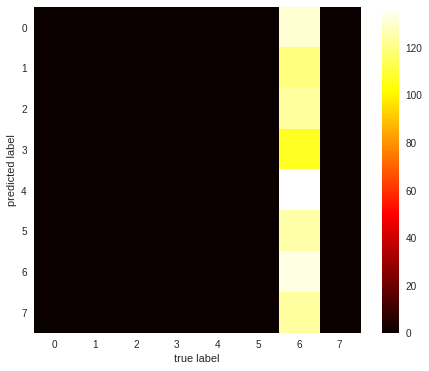

In [11]:
plt.figure(figsize=(8,6))
plt.imshow(mat, cmap='hot', interpolation='nearest')
plt.grid(False)
plt.colorbar()
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

## Assignment
* In Step 3 design your own network
* Does the model perform better if you use all three RGB channels ?
* How does the performance change when using the La*b colorspace ?
